# <b>Heart Disease Project v. 2.0.0</b>

This is it! After nearly 5 months-long hiatus the heart disease project is back on. Not only because it's a fairly straight forward dataset, but also because it's a good starting point for practicing with creating a Neural Network from the ground up. In this notebook I will follow the usual drill, that is:

 - Defining the problem
 - EDA and preprocessing the data
 - Creating the initial network and tuning it
 - Evaluating the model
 - Experimenting untill satisfied

 Just to catch up - I am working with a dataset <a href="https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci/code?select=heart_cleveland_upload.csv">from Kaggle</a> and it's an updated version of the original Cleveland heart disease dataset. It's been <u>defined</u> on the dataset page already but to reiterate - it's a binary classification problem, where the patient can be either healthy or suffer from the heart disease. The features are the parameters of each patient, and they are:

 1. age: age in years
 2. sex: sex (1 = male; 0 = female)
 3. cp: chest pain type
    <br />a) Value 0: typical angina
    <br />b) Value 1: atypical angina
    <br />c) Value 2: non-anginal pain
    <br />d) Value 3: asymptomatic
 4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
 5. chol: serum cholestoral in mg/dl
 6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
 7. restecg: resting electrocardiographic results
    <br />-- Value 0: normal
    <br />-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    <br />-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
 8. thalach: maximum heart rate achieved
 9. exang: exercise induced angina (1 = yes; 0 = no)
 10. oldpeak = ST depression induced by exercise relative to rest
 11. slope: the slope of the peak exercise ST segment
   <br />-- Value 0: upsloping
   <br />-- Value 1: flat
   <br />-- Value 2: downsloping
 12. ca: number of major vessels (0-3) colored by flourosopy
 13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
 14. condition: 0 = no disease, 1 = disease

 Let's start by importing the necessary tools. Then we will load in the dataset and explore it to refresh my memory.

In [1]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, datetime, os


from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

%load_ext tensorboard

## <u>Exploratory Data Analysis</u>

To begin we have to load in the `heart_cleveland_upload.csv` file as a Pandas DataFrame object

In [2]:
df = pd.read_csv("./heart_cleveland_upload.csv")
print(f"The shape of the DataFrame: {df.shape}") 
print(f"Value spread for the target column: \n{df['condition'].value_counts()}")
df.head()

The shape of the DataFrame: (297, 14)
Value spread for the target column: 
condition
0    160
1    137
Name: count, dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
print(f"The sum of any missing values: \n{np.sum(df.isna())}")
print("Data types for each column:") 
df.dtypes

The sum of any missing values: 
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64
Data types for each column:


age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

Through this quick exploration of the dataset items we can see that it really is a beginner friendly set - there are no missing values, every feature is either an integer or a floating point number. The problems seems rather balanced (that is there is almost as many 0 and 1 values in the target column). The length of the dataset could be bigger for a Neural Network, but for a simple exercise I think it will do. Let's visualise some data and see if there are any obvious corealtions.

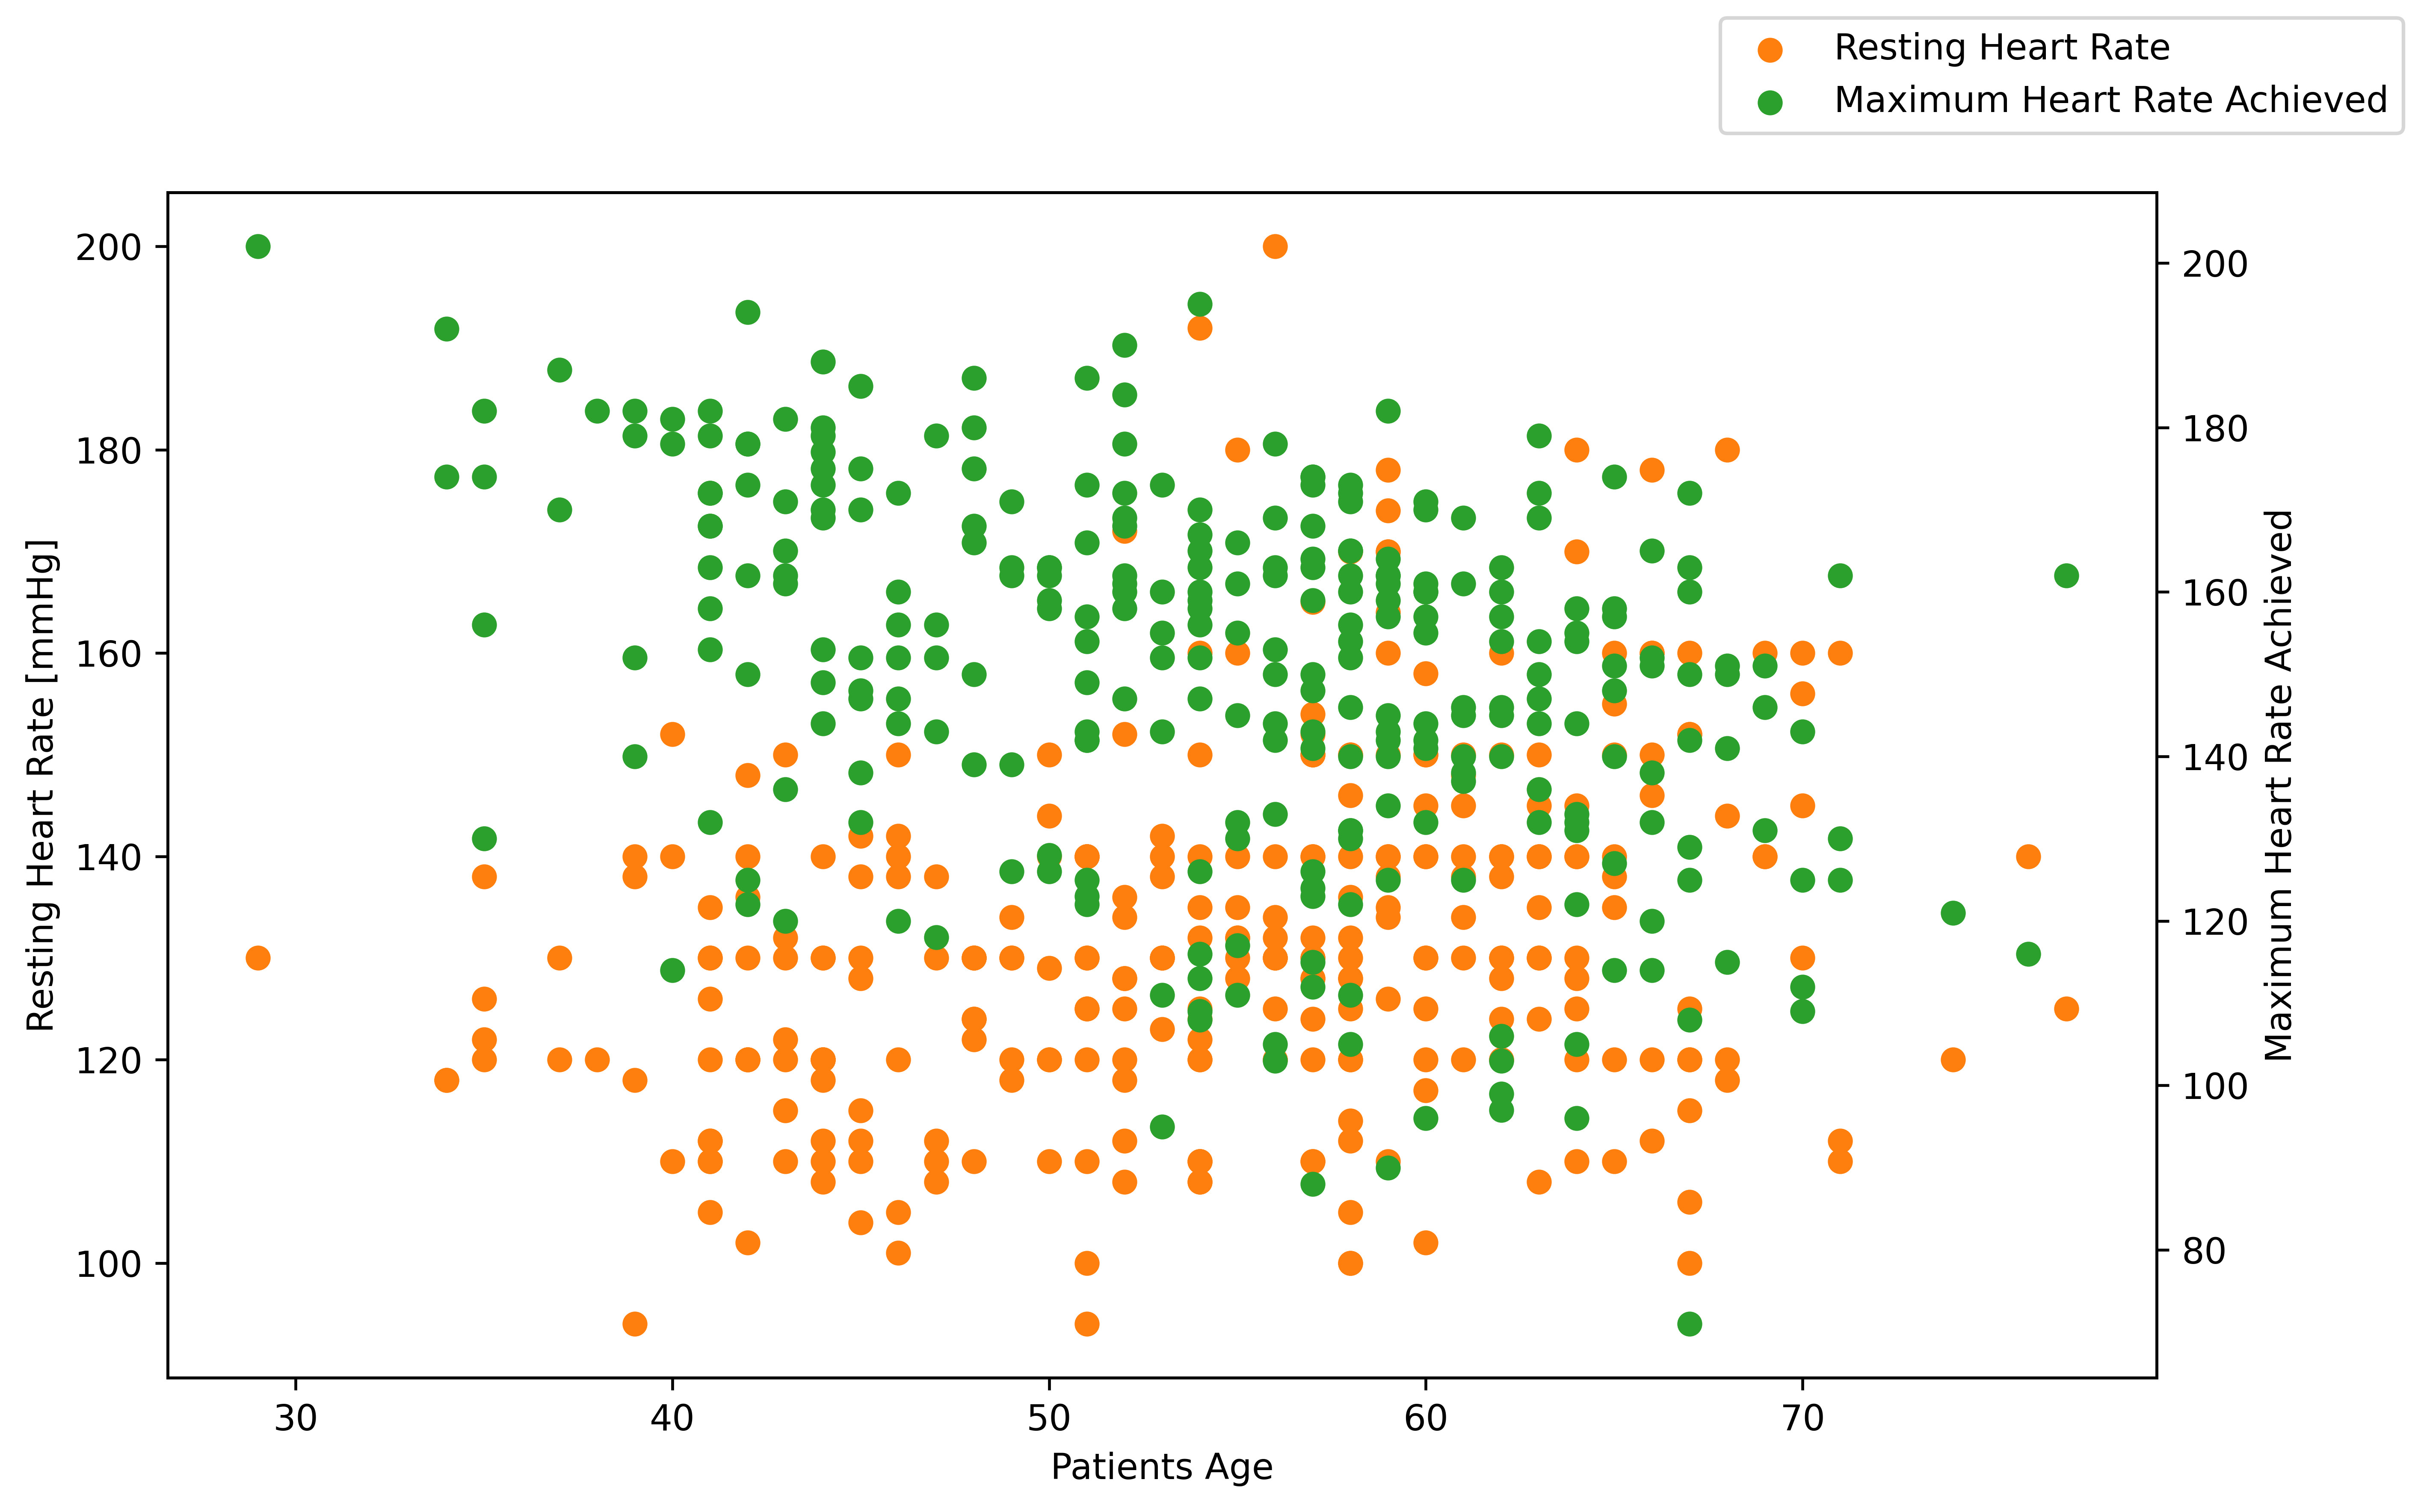

In [4]:
fig, ax = plt.subplots(figsize= (10, 6))
ax1 = ax.twinx()
ax.scatter(
    x= df["age"],
    y= df["trestbps"],
    c= "tab:orange",
    label="Resting Heart Rate"
)
ax1.scatter(
    x= df["age"],
    y= df["thalach"],
    c= "tab:green",
    label= "Maximum Heart Rate Achieved"
)

ax.set_xlabel("Patients Age")
ax.set_ylabel("Resting Heart Rate [mmHg]")
ax1.set_ylabel("Maximum Heart Rate Achieved")
fig.set_dpi(600)
fig.legend()


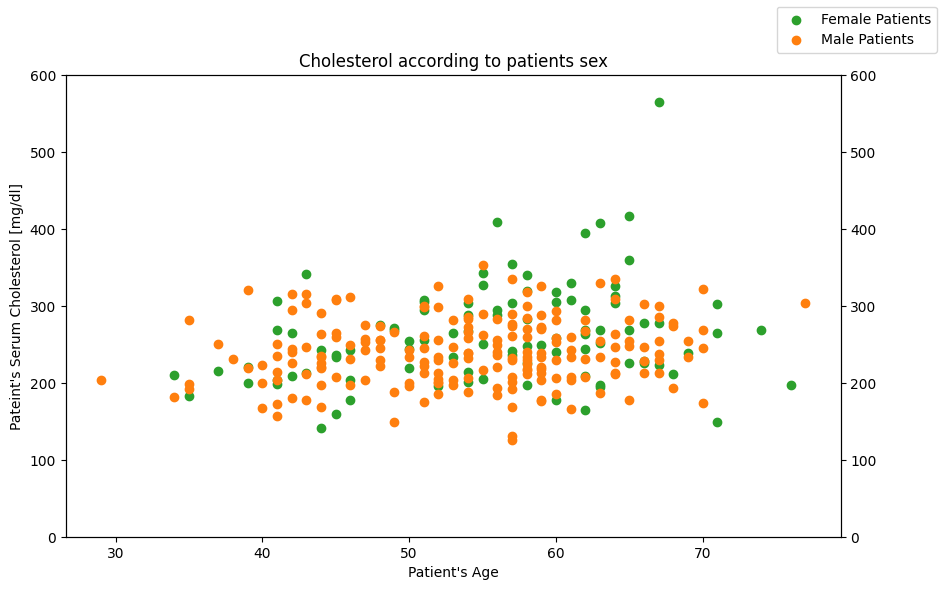

In [5]:
sex_idxs = {"female": [], "male": []}
for idx in range(len(df)):
    if df["sex"][idx] == 0:
        sex_idxs["female"].append(idx)
    else:
        sex_idxs["male"].append(idx)


fig, ax = plt.subplots(figsize=(10, 6))
ax1 = ax.twinx()
ax.scatter(
    x=df["age"][sex_idxs["female"]],
    y=df["chol"][sex_idxs["female"]],
    color= "tab:green",
    label= "Female Patients"
)
ax1.scatter(
    x= df["age"][sex_idxs["male"]],
    y= df["chol"][sex_idxs["male"]],
    color= "tab:orange",
    label= "Male Patients"
)
ax.set_title(f"Cholesterol according to patients sex")
ax.set_xlabel("Patient's Age")
ax.set_ylabel("Pateint's Serum Cholesterol [mg/dl]")
ax.set_ylim(bottom=0, top=600)
ax1.set_ylim(bottom=0, top=600)
fig.legend()

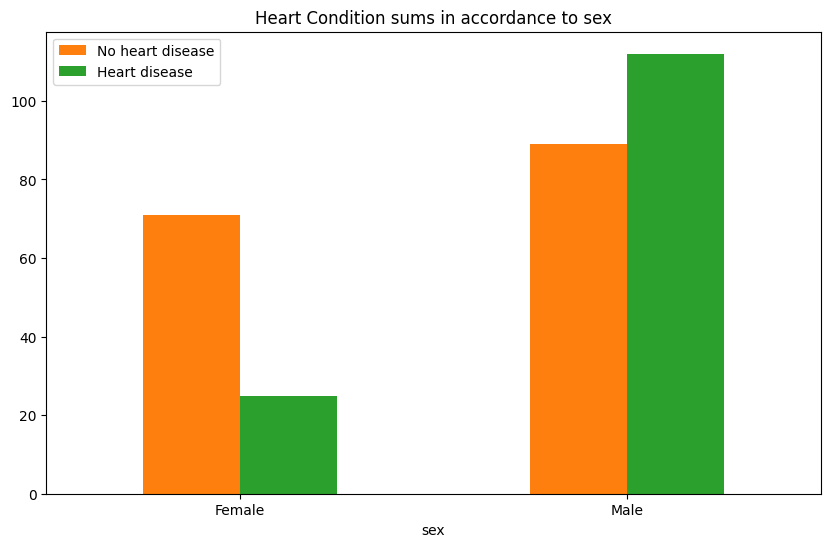

In [6]:
pd.crosstab(df["sex"], df["condition"]).plot(kind="bar", figsize=(10, 6), color=["tab:orange", "tab:green"])
plt.legend(["No heart disease", "Heart disease"])
plt.xticks(ticks=[0, 1], labels=["Female", "Male"], rotation="horizontal")
plt.title("Heart Condition sums in accordance to sex");

Now that we explored the data a little bit we can see some patterns emerging - men suffer from heart conditions more often than women. Also male cholesterol levels vary less with age, but they tend to be high, while in female cholesterol there are a few outliers but the results are on the lower end. Now that we know a bit about the data set it's time to start dividing data!

## <u>Preparing data for training</u>

### Creating Train and Test sets

Since we are dealing with a rather small dataset to begin with diluting it even more doesn't make much sense. I will start with setting up the random seed, so that the results are reproducable. Then we will divide the DataFrame into train and test sets in a 0.7:0.3 ratio with the help of `train_test_split()`.

In [7]:
# Setting up the random seed
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42) 
tf.config.experimental.enable_op_determinism()

# Creating X and y DataFrames
X = df.drop("condition", axis=1)
y = df["condition"]

# Dividing data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
len(X_train), len(X_test), len(y_train), len(y_test)

(207, 90, 207, 90)

In [8]:
y_train.value_counts()

condition
0    112
1     95
Name: count, dtype: int64

In [9]:
y_test.value_counts()

condition
0    48
1    42
Name: count, dtype: int64

### Putting data into batches

Interestingly enough I will skip it this time around - in the `IdentiBreed` <a href="https://github.com/Ale-Cie/IdentiBreed">notebooks</a> I created a function that divided the data into batches before training but now I want to try training and setting up the `batch_size` when setting the training function up.

## Building the network

I am going to start by creating a rather simple `keras.Sequential()` network that will look a little like the graph below:

<img src="https://aleksanderc.pythonanywhere.com/static/images/hdp_blueprint.png" style="width: 400px"/>

As you can see the first iteration of the network is going to be really straight forward, as it will consist of:
 - <b>BatchNormalization Input Layer</b> with size set to the number of features;
 - <b>Dense Hidden Layer</b> with 10 nodes and "relu" activation function
 - <b>Droput Hidden Layer</b> with the dropout rate of 0.3
 - <b>Dense Output Layer</b> with 1 input for each row of patient parameters and "sigmoid" activation function 

This way my network will preprocess the data, run it thorugh a layer of nodes which will have some of the connections terminated in order to prevent overfitting and then a prediction will be given. I will also create two callbacks - `EarlyStopping` and `ReduceLROnPlateau`. Let's stop talking now and get to setting up the network.


### Creating Callbacks

In [10]:
# Let's begin with defining the input_shape and making my code a little bit cleaner with the declartaion of what layers stand for
layers = tf.keras.layers
input_shape = [X_train.shape[1]]

# Now I will define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor= "binary_accuracy",
    patience= 5,
    restore_best_weights= True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor= "binary_accuracy",
    factor= 0.2,
    min_lr= 0.001,
    patience= 5,
)

def tensorboard_callback():
    """
    Creates checkpoints and saves them in a /logs folder under the date of creation.

    Returns a TensorBoard callback
    """
    logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
    return tf.keras.callbacks.TensorBoard(logdir)

### Creating the network's structure

In [11]:
# Now let's start with the model creation
model = keras.Sequential([
   layers.BatchNormalization(
      input_shape= input_shape,
      name= "Input_Layer"
      ),
   layers.Dense(
       units= 10,
       activation= "relu",
       name= "Hidden_Dense_Layer"
   ),
   layers.Dropout(
       rate= 0.3,
       name= "Hidden_Dropout_Layer"
   ),
   layers.Dense(
       units= 1,
       activation= "sigmoid",
       name= "Output_Layer"
   )
])

model.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (BatchNormaliza  (None, 13)               52        
 tion)                                                           
                                                                 
 Hidden_Dense_Layer (Dense)  (None, 10)                140       
                                                                 
 Hidden_Dropout_Layer (Dropo  (None, 10)               0         
 ut)                                                             
                                                                 
 Output_Layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 203
Trainable params: 177
Non-trainable params: 26
_______________________________________________

### Training the network

In [12]:
# Before moving on with training I have to select optimizer, loss and metrics
model.compile(
    optimizer= "adam",
    loss= "binary_crossentropy",
    metrics= ["binary_accuracy"],
)

# Since everything seems done I can go on and start training the model on the X_train and y_train sets
model.fit(
    x= X_train,
    y= y_train,
    batch_size= 20,
    epochs= 200,
    callbacks= [early_stopping, reduce_lr, tensorboard_callback()],
    verbose= True
)

Epoch 1/200


2023-07-25 21:59:40.739064: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-25 21:59:41.038223: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


11/11 [==============================] - 1s 19ms/step - loss: 0.9678 - binary_accuracy: 0.4589 - lr: 0.0010
Epoch 2/200
11/11 [==============================] - 0s 8ms/step - loss: 0.9119 - binary_accuracy: 0.4734 - lr: 0.0010
Epoch 3/200
11/11 [==============================] - 0s 8ms/step - loss: 0.7980 - binary_accuracy: 0.5556 - lr: 0.0010
Epoch 4/200
11/11 [==============================] - 0s 8ms/step - loss: 0.7699 - binary_accuracy: 0.5845 - lr: 0.0010
Epoch 5/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6913 - binary_accuracy: 0.6039 - lr: 0.0010
Epoch 6/200
11/11 [==============================] - 0s 11ms/step - loss: 0.6822 - binary_accuracy: 0.6232 - lr: 0.0010
Epoch 7/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6528 - binary_accuracy: 0.6667 - lr: 0.0010
Epoch 8/200
11/11 [==============================] - 0s 8ms/step - loss: 0.6047 - binary_accuracy: 0.7053 - lr: 0.0010
Epoch 9/200
11/11 [==============================] - 0s 8m

## Scoring the network's accuracy

Now that this simple network has been trained we can go on and score it on the test set. In order to do so I will define a simple function that will take the predictions (list of arrays) and the true_values (the y_test set). It will turn the floating point numbers from the predictions into labels, since < 0.5 means the model believes it's the 0 label, and >= 0.5 is 1 and append them to an ordered list. Then, the model will keep track of how many predictions were correct and in the very end return the score (correct predictions/all labels). 

After that I will experiment with adding a few new layers in order to check if this will boost the network's performance.

In [13]:
# We start by making predictions and displaying them to see what we are dealing with
predictions = model.predict(
    x= X_test,
    batch_size= 16
)

print(predictions)

6/6 [==============================] - 0s 3ms/step
[[0.949931  ]
 [0.84882736]
 [0.10937373]
 [0.05858531]
 [0.43323445]
 [0.26013315]
 [0.99281424]
 [0.9698313 ]
 [0.87026674]
 [0.17943867]
 [0.3525728 ]
 [0.8957098 ]
 [0.26018274]
 [0.15324402]
 [0.16927777]
 [0.84200275]
 [0.87637866]
 [0.16759096]
 [0.879989  ]
 [0.11301363]
 [0.8751843 ]
 [0.6915368 ]
 [0.08020177]
 [0.12876679]
 [0.21928695]
 [0.8577035 ]
 [0.94602126]
 [0.98957026]
 [0.2583336 ]
 [0.7375863 ]
 [0.7658634 ]
 [0.9466049 ]
 [0.5117596 ]
 [0.30721918]
 [0.6779672 ]
 [0.98947364]
 [0.5939208 ]
 [0.20898843]
 [0.9827108 ]
 [0.27705175]
 [0.09708335]
 [0.76518637]
 [0.71012604]
 [0.351056  ]
 [0.25592437]
 [0.93330026]
 [0.28622606]
 [0.94058466]
 [0.836913  ]
 [0.15621492]
 [0.5531718 ]
 [0.7155367 ]
 [0.19376177]
 [0.6290208 ]
 [0.98526865]
 [0.5443317 ]
 [0.1445622 ]
 [0.75869393]
 [0.4070676 ]
 [0.87185645]
 [0.96886426]
 [0.7572426 ]
 [0.12838355]
 [0.03046544]
 [0.96666807]
 [0.07526224]
 [0.21929203]
 [0.9652180

In [14]:
# Now that we know what the 'predictions' variable is (a list of arrays) we need to see what does the y_test look like
print(y_test)

167    1
211    1
63     0
154    0
5      0
      ..
15     0
10     1
228    1
184    1
68     0
Name: condition, Length: 90, dtype: int64


In [15]:
def score_model(predictions, true_values):
    """
    This function takes network's predictions and the true_values associated with the test set.
    It turns the probabilities of labels into actual 0 and 1 values, which are appended to a list in the correct order.
    Next it creates a list of true labels and in the end scores each predicted label against the correct one.

    returns 'score' that is accuracy
    """
    
    # Let's begin by defining the variables that we will use
    predicted_labels = []
    true_labels = []
    correct_predictions = 0

    # First step will go through every predicted array and turn them into labels 0 or 1
    for prediction in predictions:
        # We have to go to index 0, since the probability is first item in an array
        if prediction[0] < 0.5:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
    
    # Next step is going through the dataframe and append every true label to a dictionary
    for label in true_values:
        true_labels.append(label)
    
    # Now we will count the amount of correct predictions
    # To do that we will go through both predicted labels and true labels, one of both at a time and put them agains each other 
    # If the predictions is correct the amount of correct predictions increases by 1 
    for x in range(len(true_labels)):
        if predicted_labels[x] == true_labels[x]:
            correct_predictions += 1
        else:
            pass
    
    # Finally we divide the number of correct predictions by the number of all labels in the test set
    score = correct_predictions/len(true_values)

    return score 
    

In [16]:
score = score_model(
    predictions= predictions, 
    true_values= y_test
)

print("The model's accuracy is %.3f" %(score*100) + "%")

The model's accuracy is 83.333%


## Saving the network and preparing for experimentation

First iteration of this network performs quite nicely. For now, let's define a function that will save it. Next step will be experimenting with more layers and units.  

In [17]:
def save_network(model, name):
    """
    This function takes the model and a name it should be saved under.
    Model gets saved in a .h5 format file in the projects main folder.
    """
    suffix = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    path = f"./{name}_{suffix}.h5"
    model.save(path)

# save_network(
#     model= model,
#     name= "Network_v1"
# )
    